In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()
using ForwardDiff
using Test
using RobotZoo: PlanarQuadrotor
using RobotDynamics
using LinearAlgebra
using StaticArrays
using Statistics
using Plots
using Printf
using JLD2
const jldir = joinpath(dirname(@__DIR__),"test")

const FD = ForwardDiff;

# test_dict = Dict()
test_dict = load(joinpath(jldir,"q1.jld2"))

const isautograder = @isdefined autograder

include("quadrotor.jl");

  Activating environment at `~/Classes/16745_OptimalControl/hw3_solutions/Project.toml`


# Question 1: Iterative LQR (50 pts)
In this problem you'll implement iterative LQR (ilQR), the Gauss-Newton approximation of differential dynamic programming (DDP). You'll use it to generate trajectories for a planar quadrotor, including a flip. In the last part of the problem, you'll track the trajectory to make it robust to wind.

## The Model
We'll be using the same planar quadrotor model we saw in class. The dynamics are fairly simple:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v_x \\ v_z \\ \omega \\ 
\frac{1}{m} (u_1 + u_2) \sin{\theta} \\
\frac{1}{m} (u_1 + u_2) \cos{\theta} - g \\
\frac{l}{J} (u_2 - u_1) 
\end{bmatrix}
$$
with the following model parameters:
* $m$: mass (kg)
* $J$: moment of inertia
* $l$: distance between motors

In [2]:
model = PlanarQuadrotor()
const x0    = [-3, 1.0, 0, 0, 0, 0]                    # initial state
const xgoal = [+3, 1.0, 0, 0, 0, 0]                    # goal state
const nx = 6 
const nu = 2
const uhover = fill(0.5*1.0 * 9.81, nu) 

const Q = Diagonal(([ones(3) ; fill(0.1, 3)]))
const R = Diagonal(fill(1e-2, nu))
const Qf = Diagonal(fill(1e2, nx));

const dt = 0.025 
const N = 61

61

Use these functions to evaluate the continuous and discrete dynamics, as well as the discrete dynamics Jacobians.

In [3]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), x is a vector of length 6, u is a vector of length 2.

returns ẋ
"""

function dynamics(x,u)
    # planar quadrotor dynamics
    
    # parameters
    mass = 1.0 
    g = 9.81
    ℓ = 0.3 
    J = 0.2*mass*ℓ^2

     # unpack state
    px,pz,θ,vx,vz,ω = x    
    return [vx,vz,ω,(1/mass)*(u[1] + u[2])*sin(θ), (1/mass)*(u[1] + u[2])*cos(θ) - g, (ℓ/(2*J))*(u[2]-u[1])]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2,u)
    k3 = dt*dynamics(x + k2/2,u)
    k4 = dt*dynamics(x + k3,u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> rk4(_x,u,dt),x)
    B = FD.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians

# Part (a): Implement iLQR (30 pts)

## LQR Cost Function (5 pts)
Here you will create functions for calculating the costs of states/controls as well as whole trajectories. 

The objective / cost function for our optimization problem is of the following form:

$$\ell(x_{1:N}, u_{1:N-1}) = J_N(x_N) + \sum_{i=1}^{N-1} J(x_k,u_k) $$

Where the *stage cost* $J(x_k,u_k)$ is defined as:

$$J(x,u) = \frac{1}{2}(x - x_{ref})^TQ(x - x_{ref}) + \frac{1}{2}(u -u_{ref})^TR(u-u_{ref})$$

And the *terminal cost* is

$$J_N(x) = \frac{1}{2}(x - x_{ref})^TQ_f(x - x_{ref})$$

These cost functions penalize distance from a given reference trajectory. Quadratic cost functions of this form are often referred to as LQR costs.

In [4]:
# TASK: Fill out the following methods (10 pts)

function stage_cost(x,u,xref,uref)
    # LQR cost at each knot point (depends on both x and u)
    J = 0.0
    
    return J
end

function term_cost(x,xref)
    # LQR terminal cost (depends on just x)
    J = 0.0 
    
    return J
end

function trajectory_cost(X,U,Xref,Uref)
    # calculate the cost of a given trajectory 
    J = 0.0
    
    return J
end
        
function stage_cost_expansion(x,u,xref,uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = zeros(nx,nx)
    Jx = zeros(nx)
    Juu = zeros(nu,nu)
    Ju = zeros(nu)
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    Jxx = zeros(nx,nx)
    Jx = zeros(nx)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [5]:
using Random
@testset "cost tests" begin                                                             # POINTS = 5

    Xref = [copy(xgoal) for i = 1:N]
    Uref = [copy(uhover) for i = 1:N-1]
    
    X = [copy(x0) for i = 1:N]
    U = deepcopy(Uref)
    
    # costs 
    J1 = stage_cost(X[1],U[1],Xref[1],Uref[1])
    J2 = term_cost(X[N],Xref[N])
    J3 = trajectory_cost(X,U,Xref,Uref)
    
    @test stage_cost(X[1],U[1],Xref[1],Uref[1]) ≈  test_dict["J1"] atol = 1e-10        # POINTS = 0.5
    @test term_cost(X[N],Xref[N]) ≈ test_dict["J2"]  atol = 1e-10                      # POINTS = 0.5
    @test trajectory_cost(X,U,Xref,Uref) ≈ test_dict["J3"] atol = 1e-8                 # POINTS = 0.5
    
    # cost derivatives
    Jxx, Jx, Juu, Ju = stage_cost_expansion(X[4],U[4],Xref[4],Uref[4])                 # POINTS = 1
    
    @test vec(Jxx) ≈ vec(test_dict["Jxx"]) atol =1e-10                                 # POINTS = 0.5
    @test Jx ≈ test_dict["Jx"] atol = 1e-8                                             # POINTS = 0.5
    @test vec(Juu) ≈ vec(0.01*I(nu)) atol = 1e-8                                       # POINTS = 0.5
    @test Ju ≈ test_dict["Ju"] atol = 1e-8
    
    Jxx2, Jx2 = term_cost_expansion(X[8],Xref[8])
    
    @test vec(Jxx2) ≈ vec(test_dict["Jxx2"]) atol = 1e-8                               # POINTS = 0.5
    @test Jx2 ≈ vec(test_dict["Jx2"]) atol = 1e-8;                                     # POINTS = 0.5

end;

cost tests: Test Failed at In[5]:15
  Expression: ≈(stage_cost(X[1], U[1], Xref[1], Uref[1]), test_dict["J1"], atol = 1.0e-10)
   Evaluated: 0.0 ≈ 18.0 (atol=1.0e-10)
Stacktrace:
 [1] macro expansion
   @ In[5]:15 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[5]:4
cost tests: Test Failed at In[5]:16
  Expression: ≈(term_cost(X[N], Xref[N]), test_dict["J2"], atol = 1.0e-10)
   Evaluated: 0.0 ≈ 1800.0 (atol=1.0e-10)
Stacktrace:
 [1] macro expansion
   @ In[5]:16 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[5]:4
cost tests: Test Failed at In[5]:17
  Expression: ≈(trajectory_cost(X, U, Xref, Uref), test_dict["J3"], atol = 1.0e-8)
   Evaluated: 0.0 ≈ 2880.0 (atol=1.0e-8)
Stacktrace:
 [1] macro expansion
   @ In[5]:17 [inlined]
 [2] macro expansion
   @

LoadError: [91mSome tests did not pass: 1 passed, 8 failed, 0 errored, 0 broken.[39m

## Backward Pass (10 pts)
You will now implement the backwards pass of iLQR. Remember that iLQR has two parts, a backward pass and a forward pass.  The backward pass is where feedforward controls `d` and feedback gains `K` are solved for. 

Hint: initialize $\Delta J$ as 0, and during each step of the backwards pass, add $g_u^Td_k$ to it. 

In [48]:
"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X,U,Xref,Uref)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term
    p = [zeros(nx) for i = 1:N]        # cost to go linear term 
    d = [zeros(nu)*NaN for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = NaN                           # expected cost decrease
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [26]:
@testset "backward pass" begin                       # POINTS = 10
    
    X = test_dict["X"]
    U = test_dict["U"]
    Xref = test_dict["Xref"]
    Uref = test_dict["Uref"]
    
    d, K, P, ΔJ = backward_pass(X,U,Xref,Uref)
    
    @test d ≈ test_dict["d"] atol=1e-6              # POINTS = 3
    @test K ≈ test_dict["K"] atol=1e-6              # POINTS = 3
    @test P ≈ test_dict["P"] atol=1e-6              # POINTS = 2
    @test ΔJ ≈ test_dict["ΔJ"] atol = 1e-3          # POINTS = 2
    
end;
    

backward pass: Test Failed at In[26]:10
  Expression: ≈(d, test_dict["d"], atol = 1.0e-6)
   Evaluated: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]  …  [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]] ≈ [[26.960963421436393, -26.960965259570152], [27.292382823477517, -27.292384228113573], [27.659827118342697, -27.659828192964863], [28.065852669639007, -28.065853493225234], [28.513034981159393, -28.513035613886622], [29.003939359943104, -29.00393984758843], [29.541084151408036, -29.541084528739617], [30.126894882756783, -30.12689517614206], [30.76364734329729, -30.763647572706144], [31.453397304254445, -31.453397484794568]  …  [13.316362609268298, -13.316362609270874], [11.479666513922316, -11.479666513923947], [9.65271229599513, -9.652712295996151], [7.797929634992102, -7.797929634992723], [5.918558882245144, -5.918558882245498], [4.09165997

   Evaluated: [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

LoadError: [91mSome tests did not pass: 0 passed, 4 failed, 0 errored, 0 broken.[39m

## Forward Pass (10 pts)
Next we will build out forward pass function. This is where we do a forward simulation with the new `d` and `K`'s from the backwards pass, and do a backtracking line search on $\alpha$ to ensure we see a neccessary decrease. During our linesearch, we accept our new trajectory/control if the following Armijo condition is satsified:

$$ J_n < J - 0.01\alpha\Delta J$$

In [49]:
function forward_pass(X,U,Xref,Uref,K,d,ΔJ; max_linesearch_iters = 10)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    Jn = NaN
    α = NaN
        
    return Xn, Un, Jn, α
end

forward_pass (generic function with 1 method)

In [50]:
@testset "forward pass" begin                              # POINTS = 10
    
    Xref = [copy(xgoal) for i = 1:N]
    Uref = [copy(uhover) for i = 1:N-1]
    
    X = [copy(x0) for i = 1:N]
    U = deepcopy(Uref)
    
    d, K, P, ΔJ = backward_pass(X,U,Xref,Uref)
    
    Xn, Un, Jr, α = forward_pass(X,U,Xref,Uref,K,d,ΔJ)
    
    @test Xn ≈ test_dict["Xn"] atol=1e-6                  # POINTS = 4
    @test Un ≈ test_dict["Un"] atol=1e-6                  # POINTS = 2
    @test Jr ≈ test_dict["Jr"] atol = 1e-6                # POINTS = 2
    @test α ≈ test_dict["α"]  atol = 1e-6                 # POINTS = 2
    
end;

forward pass: Test Failed at In[50]:13
  Expression: ≈(Xn, test_dict["Xn"], atol = 1.0e-6)
   Evaluated: [[-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0]  …  [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-3.0, 1.0, 0.0, 0.0, 0.0, 0.0]] ≈ [[-3.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-2.9999283122118254, 0.9999974829100041, 0.14042168927345458, 0.011455916335940439, -0.0006036972702069118, 11.233735141876366], [-2.998916698915424, 0.9998888858268639, 0.45278869652466847, 0.0

LoadError: [91mSome tests did not pass: 0 passed, 4 failed, 0 errored, 0 broken.[39m

## iLQR Algorithm (5 pts)
Now we are going to put it all together, we are given an initial condition `x0` and an unitial control input history `U`, and a reference trajectory `Xref` and `Uref`. We will start by doing a forward simulation starting from `x0` using `U` as the control input, creating `X`. Then we will start our main loop. In each iteartion, we do the following:

- backward pass 
- check termination criteria 
- forward pass 


In [51]:
"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition Vector
    U - initial control history Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track Vector{Vector}

outputs:
    X - optimal trajectory Vector{Vector}
    U - optimal control trajectory Vector{Vector}
    K - feedback gain matrices Vector{Matrix}
    P - cost to go hessians Vector{Matrix}
    iter - iterations it took to converge Int
"""
function iLQR(x0,U,Xref,Uref;atol=1e-5,max_iters = 100,verbose = true)
    
    # inital logging stuff 
    if isautograder
        verbose = false
    end
    if verbose
        @printf "iter     J           ΔJ        |d|         α\n"
        @printf "-----------------------------------------------\n"
    end
    X = [zeros(nx)*NaN for i = 1:N]
    U = [u * NaN for u in U]
    K = [zeros(nu,nx)*NaN for i = 1:N-1]
    P = [zeros(nx,nx)*NaN for i = 1:N]
    iter = -1

    return X,U,K,P,iter

end
        

iLQR

## Part (b): Simple trajectory (5 pts)
Use your iLQR solver to move the quadrotor from the initial state to the goal state.

In [52]:
# reference trajectory (we just want to track the goal state and hover control)
Xrefline = [copy(xgoal) for i = 1:N]
Urefline = [copy(uhover) for i = 1:N-1]

# call iLQR
Xline,Uline,Kline,Pline, iterline = iLQR(x0,Urefline,Xrefline,Urefline);

iter     J           ΔJ        |d|         α
-----------------------------------------------


In [53]:
@testset "iLQR" begin                                                     # POINTS = 10
    @test trajectory_cost(Xline,Uline,Xrefline,Urefline) <4.8e2           # POINTS = 1
    @test iterline < 50                                                   # POINTS = 1                      
    @test iterline > 30                                                   # POINTS = 1
    @test norm(Xline[end] - xgoal) < 0.2                                  # POINTS = 1
    @test maximum(maximum.(Uline)) < 40                                   # POINTS = 1
    @test maximum(maximum.(Uline)) > 30                                   # POINTS = 1
    @test minimum(minimum.(Uline)) < -30                                  # POINTS = 1
    @test minimum(minimum.(Uline)) > -40                                  # POINTS = 1
    
    d, K, P, ΔJ = backward_pass(Xline,Uline,Xrefline,Urefline)
    
    @test ΔJ < 1e-4                                                       # POINTS = 1
    @test maximum(norm.(d)) < 1e-3                                        # POINTS = 1
end;

iLQR: Test Failed at In[53]:4
  Expression: iterline > 30
   Evaluated: -1 > 30
Stacktrace:
 [1] macro expansion
   @ In[53]:4 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[53]:2
iLQR: Test Failed at In[53]:5
  Expression: norm(Xline[end] - xgoal) < 0.2
   Evaluated: NaN < 0.2
Stacktrace:
 [1] macro expansion
   @ In[53]:5 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[53]:2
iLQR: Test Failed at In[53]:6
  Expression: maximum(maximum.(Uline)) < 40
   Evaluated: NaN < 40
Stacktrace:
 [1] macro expansion
   @ In[53]:6 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[53]:2
iLQR: Test Failed at In[53]:7
  Expression: maximum(maximum.(Uli

LoadError: [91mSome tests did not pass: 2 passed, 8 failed, 0 errored, 0 broken.[39m

In [33]:
if !isautograder
    vis = Visualizer()
    set_mesh!(vis, model)
    render(vis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/brian/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [34]:
isautograder || visualize!(vis, model, dt*(N-1), Xline)

## Part (c): Generate Cost function for Flip (5 pts)
Now that we have a working iLQR solver, let's do something more interesting than just getting it to fly in a straight line. Let's do a flip!

Generate a reference trajectory for the cost function. Since we're designing it by hand we'll do something simple. Complete the function below to generate a trajectory that does the following:
* 0.0-0.5 sec: Moves linearly from -3 to 0 in x, $p_z=1$, $\omega=0$
* 0.5-1.0 sec: Moves linearly from 1 to 3 and back to 1 in z. $\theta$ goes from 0 to -2$\pi$. No movement in x.
* 1.0-1.5 sec: Moves linearly from 0 to 3 in x.

The velocities should be consistent with the positions and the changes between phases should happen at all the same indices as the positions.

The trajectory should look like the following:
![flip_traj](flip_reference.png)

In [42]:
# TASK: Implement the following method
"""
    flip_reference

Generate a reference trajectory for the quadrotor that encourages it to do a flip.
The trajectory should have a length of 61.

hint: LinRange is a good function to use
        `LinRange(start,stop,length)`

hint: you can break up the time indexing like this:
    0    - 0.5  sec: indices 1:20
    0.5  - 0.75 sec: indices 21:30
    0.75 - 1.0  sec: indices 31:40
    1.0  - 1.5  sec: indices 41:61

You should plot your reference trajectory to ensure it looks like the given plot.
"""
function flip_reference()
    # TODO: Design the reference trajectory according to the specs above
    x1ref = zeros(61)*NaN
    x2ref = zeros(61)*NaN
    θref = zeros(61)*NaN
    v1ref = zeros(61)*NaN
    v2ref = zeros(61)*NaN
    ωref = zeros(61)*NaN
    
    xref = [x1ref'; x2ref'; θref'; v1ref'; v2ref'; ωref']
    return [x for x in eachcol(xref)]
end

flip_reference

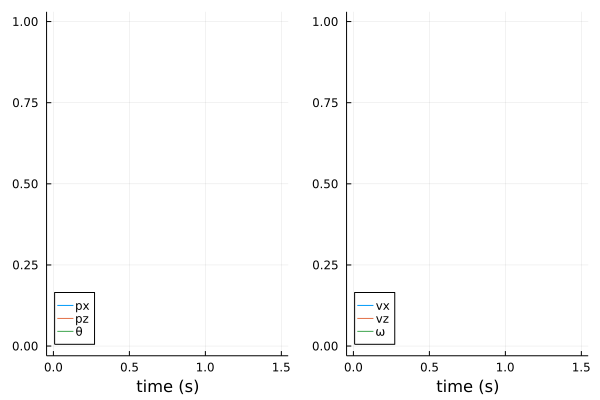

In [43]:
# Plot the reference trajectory and compare with the given plot
Xref = flip_reference()

# convert to static arrays and plot
Xref = [SVector{6}(Xref[i]) for i = 1:length(Xref)]
if !isautograder
    p = plot(layout=(1,2))
    plot!(p[1], 0:dt:(N-1)*dt, Xref, inds=1:3, xlabel="time (s)", labels = ["px" "pz" "θ"], legend=:bottomleft)
    plot!(p[2], 0:dt:(N-1)*dt, Xref, inds=4:6, xlabel="time (s)", labels = ["vx" "vz" "ω"], legend=:bottomleft)
end

In [54]:
@testset "flip reference" begin                            # POINTS = 5
    Xref_ = flip_reference()
    @test length(Xref_) == 61                              # POINTS = 0.5
    Xref_ = hcat(Vector.(Xref_)...)
    @test mean(diff(Xref_[1,1:21])) ≈ 3/20 atol=1e-1       # POINTS = 0.5
    @test mean(Xref_[4,1:20]) ≈ 6.0 atol=1e-1              # POINTS = 0.5
    @test mean(Xref_[1,21:40]) ≈ 0 atol=1e-1               # POINTS = 0.5 
    @test mean(diff(Xref_[1,41:end])) ≈ 3/20 atol=1e-1     # POINTS = 0.5
    @test mean(Xref_[4,41:end]) ≈ 6.0 atol=1e-1            # POINTS = 0.5

    @test Xref_[3,1] ≈ 0 atol=1e-6                         # POINTS = 0.5
    @test Xref_[3,end] ≈ -2pi atol = 1e-6                  # POINTS = 0.5
    @test std(diff(Xref_[6,21:40])) < 0.1                  # POINTS = 0.5
    @test std(diff(Xref_[4,21:40])) < 0.1                  # POINTS = 0.5
end;

flip reference: Test Failed at In[54]:5
  Expression: ≈(mean(diff(Xref_[1, 1:21])), 3 / 20, atol = 0.1)
   Evaluated: NaN ≈ 0.15 (atol=0.1)
Stacktrace:
 [1] macro expansion
   @ In[54]:5 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[54]:2
flip reference: Test Failed at In[54]:6
  Expression: ≈(mean(Xref_[4, 1:20]), 6.0, atol = 0.1)
   Evaluated: NaN ≈ 6.0 (atol=0.1)
Stacktrace:
 [1] macro expansion
   @ In[54]:6 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[54]:2
flip reference: Test Failed at In[54]:7
  Expression: ≈(mean(Xref_[1, 21:40]), 0, atol = 0.1)
   Evaluated: NaN ≈ 0 (atol=0.1)
Stacktrace:
 [1] macro expansion
   @ In[54]:7 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/T

LoadError: [91mSome tests did not pass: 1 passed, 9 failed, 0 errored, 0 broken.[39m

## Part (d): Optimize the Flip Trajectory (2 pts)
Using the reference trajectory and the objective you specified in the previous part, construct a new problem and solve it with your iLQR solver. Use a simple hover trajectory as the initial guess.

In [45]:
# TODO: Solve for Xflip, Uflip, the optimized trajectories to flip the quadrotor

Uref = [copy(uhover) for i = 1:N-1]
Xflip,Uflip,Kflip,Pflip,iterflip = iLQR(x0,Uref,Xref,Uref);

iter     J           ΔJ        |d|         α
-----------------------------------------------


In [46]:
isautograder || render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8701))

In [22]:
isautograder || visualize!(vis, model, dt*(N-1), Xflip)

In [55]:
@testset "Flip trajectory" begin                                # POINTS = 2
    @test minimum([abs(rad2deg(x[3])+180) for x in Xflip]) < 5  # POINTS = 1
    d, K, P, ΔJ = backward_pass(Xflip,Uflip,Xref,Uref)
    @test norm(d, Inf) < 1e-5                                   # POINTS = 1
end;

Flip trajectory: Test Failed at In[55]:2
  Expression: minimum([abs(rad2deg(x[3]) + 180) for x = Xflip]) < 5
   Evaluated: NaN < 5
Stacktrace:
 [1] macro expansion
   @ In[55]:2 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[55]:2
Flip trajectory: Test Failed at In[55]:4
  Expression: norm(d, Inf) < 1.0e-5
   Evaluated: NaN < 1.0e-5
Stacktrace:
 [1] macro expansion
   @ In[55]:4 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[55]:2
Test Summary:   | Fail  Total
Flip trajectory |    2      2


LoadError: [91mSome tests did not pass: 0 passed, 2 failed, 0 errored, 0 broken.[39m

## Part (e): Compare to TVLQR (3 pts)
iLQR generates a local linear feedback controller. As we saw in class, the backwardpass in iLQR is basically TVLQR with some extra terms. However, as our trajectory converges to a stationary point, these extra linear terms should go to zero. When iLQR exits, theses local feedback gains should closely match the result out of TVLQR. Using your code from the previous homework, generate a TVLQR solution for the optimized flip trajectory, using the same cost matrices used in your iLQR solver. They should match to reasonable numerical precision.

In [56]:
# TODO: Generate Klqr, Plqr, the feedback and cost-to-go matrices from TVLQR
#       to track the optimized flip trajectory

Klqr = deepcopy(Kflip) .* NaN
Plqr = deepcopy(Pflip) .* NaN


61-element Vector{Matrix{Float64}}:
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN;

In [57]:
@testset "TVLQR vs iLQR" begin                      # POINTS = 3
    @test maximum(norm.(Kflip - Klqr,Inf)) < 1e-3   # POINTS = 2
    @test maximum(norm.(Pflip - Plqr,Inf)) < 1e-3   # POINTS = 1
end;

TVLQR vs iLQR: Test Failed at In[57]:2
  Expression: maximum(norm.(Kflip - Klqr, Inf)) < 0.001
   Evaluated: NaN < 0.001
Stacktrace:
 [1] macro expansion
   @ In[57]:2 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[57]:2
TVLQR vs iLQR: Test Failed at In[57]:3
  Expression: maximum(norm.(Pflip - Plqr, Inf)) < 0.001
   Evaluated: NaN < 0.001
Stacktrace:
 [1] macro expansion
   @ In[57]:3 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[57]:2
Test Summary: | Fail  Total
TVLQR vs iLQR |    2      2


LoadError: [91mSome tests did not pass: 0 passed, 2 failed, 0 errored, 0 broken.[39m

## Part (f): Closed-Loop Tracking (5 pts)
Now that we've seen that the controller generated by iLQR is nearly identical to the TVLQR solution with the same cost matrices, let's use the iLQR gains to track our trajectory, and see how robust it is to wind gusts. We will produce this noise in the following way:

$$x_{k+1} = \operatorname{rk4}(x_k,u_k,dt) + [0,0,0,0.1\cdot\operatorname{randn}(3)]$$

**NOTE** This is a pretty simple approximation of disturbances like wind. A better way to do this would be to inject external forces directly into the continuous dynamics.

In [58]:
using Random
"""
function for simulating with noise 

inputs:
    x0 - initial condition 
    Xflip - optimal flip trajectory from iLQR 
    Uflip - optimal flip control from iLQR 
    Kflip - feedback gain matrices from iLQR
    open_loop - bool, if true, use only Uflip as control, if false, use the feedback gain as well 

outputs:
    X - simulated X
    U - simulated U 
"""
function simulate_with_noise(x0,Xflip,Uflip,Kflip,open_loop)
    
    X = [zeros(nx) for i = 1:N]
    U = [zeros(nu) for i = 1:N-1]
    X[1] = copy(x0)
    
    Random.seed!(1)
    
    # TODO: simulate with added noise from wind 
    # use open_loop to determine what control you should apply 

    return X,U
end


Xlqr,Ulqr = simulate_with_noise(x0,Xflip,Uflip,Kflip,false);
Xopen,Uopen = simulate_with_noise(x0,Xflip,Uflip,Kflip,true);

In [59]:
isautograder || render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8701))

In [60]:
# Simulate with LQR
isautograder || visualize!(vis, model, dt*(N-1), Xlqr)

In [61]:
isautograder || visualize!(vis, model, dt*(N-1), Xopen)

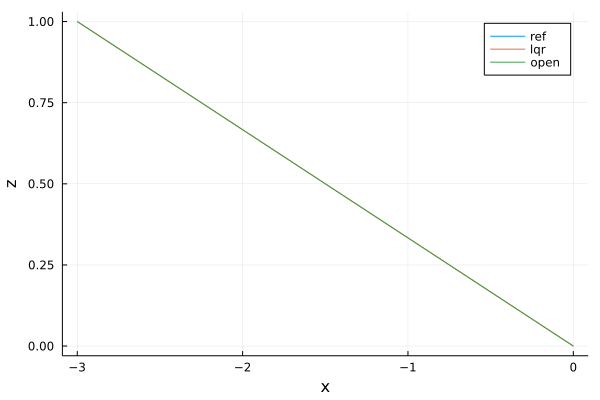

In [62]:
# Plot the trajectories
Xflip = SVector{nx}.(Xflip)
Xlqr = SVector{nx}.(Xlqr)
Xopen = SVector{nx}.(Xopen)
if !isautograder
    traj2(Xflip, label="ref")
    traj2!(Xlqr, label="lqr")
    traj2!(Xopen, label="open", ylabel="z")
end

In [63]:
@testset "open loop vs closed loop" begin                                  # POINTS = 5
    @test norm(Xflip[end][1:2] - Xlqr[end][1:2]) < 0.5                     # POINTS = 3
    @test norm(Xflip[end] - Xlqr[end]) < norm(Xflip[end] - Xopen[end])     # POINTS = 2
end;

open loop vs closed loop: Test Failed at In[63]:2
  Expression: norm((Xflip[end])[1:2] - (Xlqr[end])[1:2]) < 0.5
   Evaluated: NaN < 0.5
Stacktrace:
 [1] macro expansion
   @ In[63]:2 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[63]:2
open loop vs closed loop: Test Failed at In[63]:3
  Expression: norm(Xflip[end] - Xlqr[end]) < norm(Xflip[end] - Xopen[end])
   Evaluated: NaN < NaN
Stacktrace:
 [1] macro expansion
   @ In[63]:3 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[63]:2
Test Summary:            | Fail  Total
open loop vs closed loop |    2      2


LoadError: [91mSome tests did not pass: 0 passed, 2 failed, 0 errored, 0 broken.[39m